###### !pip install torchsummary

In [1]:
!pip install torchsummary

In [2]:
import random
import torch


class ImagePool():
    #训练判别器时，减少模型震荡。
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:  # 创建一个空池
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        '''
        接受一组图像作为输入。对于每个输入图像，如果缓冲池未满，则将其插入缓冲池。
        如果缓冲池已满，则有50%的概率从缓冲池中随机选择一张图像并将其替换为当前图像，
        然后返回被替换的图像；还有50%的概率直接返回当前图像。
        最后，将所有返回的图像收集起来，并作为一个张量返回。
        '''
        if self.pool_size == 0:  # 如果缓冲区大小为0，则不执行任何操作
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # 如果缓冲区未满；继续将当前图像插入缓冲区
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # 有50%的概率缓冲区将返回先前存储的图像，并将当前图像插入缓冲区
                    random_id = random.randint(0, self.pool_size - 1) 
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # 还有50%的可能性，缓冲区将返回当前图像
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # 收集所有图像并返回
        return return_images

In [3]:
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transform
from PIL import Image
import glob
import os
import numpy as np


class CreateDatasets(Dataset):
    def __init__(self, root_path, img_size, mode):
        if mode == 'train':
            A_img_path = os.path.join(root_path, 'trainA')
            B_img_path = os.path.join(root_path, 'trainB')
        elif mode == 'test':
            A_img_path = os.path.join(root_path, 'testA')
            B_img_path = os.path.join(root_path, 'testB')
        else:
            raise NotImplementedError('mode {} is error}'.format(mode))

        self.A_img_list = glob.glob(A_img_path + '/*.jpg')
        self.B_img_list = glob.glob(B_img_path + '/*.jpg')
        self.transform = transform.Compose([
            transform.ToTensor(),# 转为tensor
            transform.Resize((img_size, img_size), antialias=True),# 调整大小
            transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))# 归一化
        ])

    def __len__(self):
        return len(self.A_img_list)

    def __getitem__(self, item):
        A_index = item % len(self.A_img_list)
        A_img = Image.open(self.A_img_list[A_index])
        B_index = np.random.randint(0, len(self.B_img_list) - 1)
        B_img = Image.open(self.B_img_list[B_index])
        A_img = self.transform(A_img)
        B_img = self.transform(B_img)
        return A_img, B_img


In [4]:
import torchvision
from tqdm import tqdm
import torch
import os

# 训练一个epoch
# Ga:生成A的生成器
# Da:判别A的判别器
# Gb:生成B的生成器
# Db:判别B的判别器
# train_loader:训练数据集
# optim_G:生成器的优化器
# optim_D:判别器的优化器
# writer:tensorboardX的writer
# loss:损失函数
# device:设备
# plot_every:每隔多少个batch绘制一次结果
# epoch:当前epoch
# l1_loss:平滑损失
# A_fake_pool:假A的缓冲区
# B_fake_pool:假B的缓冲区
def train_one_epoch(Ga, Da, Gb, Db, train_loader, optim_G, optim_D, writer, loss, device, plot_every, epoch, l1_loss,
                    A_fake_pool, B_fake_pool):
    pd = tqdm(train_loader)
    loss_D, loss_G = 0, 0
    step = 0
    Ga.train()
    Da.train()
    Gb.train()
    Db.train()
    for idx, data in enumerate(pd):
        A_real = data[0].to(device)
        B_real = data[1].to(device)
        # 前向传递
        B_fake = Ga(A_real)  # Ga生成的假B
        A_rec = Gb(B_fake)  # Gb重构回的A
        A_fake = Gb(B_real)  # Gb生成的假A
        B_rec = Ga(A_fake)  # Ga重构回的B

        # 训练G   => G包含六部分损失
        set_required_grad([Da, Db], requires_grad=False)  # 不更新D
        optim_G.zero_grad()
        # 生成器的损失
        ls_G = train_G(Da=Da, Db=Db, B_fake=B_fake, loss=loss, A_fake=A_fake, l1_loss=l1_loss,
                       A_rec=A_rec,
                       A_real=A_real, B_rec=B_rec, B_real=B_real, Ga=Ga, Gb=Gb)
        ls_G.backward()
        optim_G.step()

        # 训练D 
        # 从缓冲区中取出假A和假B
        set_required_grad([Da, Db], requires_grad=True)
        optim_D.zero_grad()
        # 从缓冲区中取出假A和假B
        A_fake_p = A_fake_pool.query(A_fake)
        B_fake_p = B_fake_pool.query(B_fake)
        ls_D = train_D(Da=Da, Db=Db, B_fake=B_fake_p, B_real=B_real, loss=loss, A_fake=A_fake_p, A_real=A_real)
        ls_D.backward()
        optim_D.step()

        loss_D += ls_D
        loss_G += ls_G

        pd.desc = 'train_{} G_loss: {} D_loss: {}'.format(epoch, ls_G.item(), ls_D.item())

        # 绘制训练结果
        if idx % plot_every == 0:
            writer.add_images(tag='epoch{}_Ga'.format(epoch), img_tensor=0.5 * (torch.cat([A_real, B_fake], 0) + 1),
                              global_step=step)
            writer.add_images(tag='epoch{}_Gb'.format(epoch), img_tensor=0.5 * (torch.cat([B_real, A_fake], 0) + 1),
                              global_step=step)
            step += 1
    mean_lsG = loss_G / len(train_loader)
    mean_lsD = loss_D / len(train_loader)
    return mean_lsG, mean_lsD


@torch.no_grad()
def val(Ga, Da, Gb, Db, val_loader, loss, device, l1_loss, epoch):
    pd = tqdm(val_loader)
    loss_D, loss_G = 0, 0
    Ga.eval()
    Da.eval()
    Gb.eval()
    Db.eval()
    all_loss = 10000
    for idx, item in enumerate(pd):
        A_real_img = item[0].to(device)
        B_real_img = item[1].to(device)

        B_fake_img = Ga(A_real_img)
        A_fake_img = Gb(B_real_img)

        A_rec = Gb(B_fake_img)
        B_rec = Ga(A_fake_img)

        # D的loss
        ls_D = train_D(Da=Da, Db=Db, B_fake=B_fake_img, B_real=B_real_img, loss=loss, A_fake=A_fake_img,
                       A_real=A_real_img)
        # G的loss
        ls_G = train_G(Da=Da, Db=Db, B_fake=B_fake_img, loss=loss, A_fake=A_fake_img, l1_loss=l1_loss,
                       A_rec=A_rec,
                       A_real=A_real_img, B_rec=B_rec, B_real=B_real_img, Ga=Ga, Gb=Gb)

        loss_G += ls_G
        loss_D += ls_D
        pd.desc = 'val_{}: G_loss:{} D_Loss:{}'.format(epoch, ls_G.item(), ls_D.item())

        # 保存最好的结果
        all_ls = ls_G + ls_D
        if all_ls < all_loss:
            all_loss = all_ls
            best_image = torch.cat([A_real_img, B_fake_img, B_real_img, A_fake_img], 0)
    result_img = (best_image + 1) * 0.5
    if not os.path.exists('./results'):
        os.mkdir('./results')

    torchvision.utils.save_image(result_img, './results/val_epoch{}_cycle.jpg'.format(epoch))


# 设置是否需要梯度，用于训练G和D，当训练G时，不需要更新D的参数，反之亦然
def set_required_grad(nets, requires_grad=False):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for params in net.parameters():
                params.requires_grad = requires_grad

# 训练G，GAN损失，循环损失，平滑损失
def train_G(Da, Db, B_fake, loss, A_fake, l1_loss, A_rec, A_real, B_rec, B_real, Ga, Gb):
    # GAN loss
    Da_out_fake = Da(B_fake)
    Ga_gan_loss = loss(Da_out_fake, torch.ones(Da_out_fake.size()).cuda())
    Db_out_fake = Db(A_fake)
    Gb_gan_loss = loss(Db_out_fake, torch.ones(Db_out_fake.size()).cuda())

    # Cycle loss
    Cycle_A_loss = l1_loss(A_rec, A_real) * 10
    Cycle_B_loss = l1_loss(B_rec, B_real) * 10

    # identity loss
    Ga_id_out = Ga(B_real)
    Gb_id_out = Gb(A_real)
    Ga_id_loss = l1_loss(Ga_id_out, B_real) * 10 * 0.5
    Gb_id_loss = l1_loss(Gb_id_out, A_real) * 10 * 0.5

    # G的总损失
    ls_G = Ga_gan_loss + Gb_gan_loss + Cycle_A_loss + Cycle_B_loss + Ga_id_loss + Gb_id_loss

    return ls_G

# 训练D，判别器的损失为真实图片的损失和假图片的损失
def train_D(Da, Db, B_fake, B_real, loss, A_fake, A_real):
    # Da的loss
    Da_fake_out = Da(B_fake.detach()).squeeze()
    Da_real_out = Da(B_real).squeeze()
    ls_Da1 = loss(Da_fake_out, torch.zeros(Da_fake_out.size()).cuda())
    ls_Da2 = loss(Da_real_out, torch.ones(Da_real_out.size()).cuda())
    ls_Da = (ls_Da1 + ls_Da2) * 0.5
    # Db的loss
    Db_fake_out = Db(A_fake.detach()).squeeze()
    Db_real_out = Db(A_real.detach()).squeeze()
    ls_Db1 = loss(Db_fake_out, torch.zeros(Db_fake_out.size()).cuda())
    ls_Db2 = loss(Db_real_out, torch.ones(Db_real_out.size()).cuda())
    ls_Db = (ls_Db1 + ls_Db2) * 0.5

    # D的总损失
    ls_D = ls_Da + ls_Db
    return ls_D


In [5]:
import torch.nn as nn
from torchsummary import summary
from collections import OrderedDict


# 定义残差块
class Resnet_block(nn.Module):
    def __init__(self, in_channels):
        super(Resnet_block, self).__init__()
        block = []
        for i in range(2):
            block += [nn.ReflectionPad2d(1),
                      # 保证输出的大小不变，3*3的卷积核，padding=1，0为填充值
                      nn.Conv2d(in_channels, in_channels, 3, 1, 0),
                      #InstanceNorm2d为归一化，in_channels为通道数，用于处理图像，将图像的每个通道独立的归一化
                      nn.InstanceNorm2d(in_channels),
                      #nn.Identity()为恒等映射，对输入不做任何处理
                      #否则使用nn.ReLU(True)激活函数
                      nn.ReLU(True) if i > 0 else nn.Identity()]
        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = x + self.block(x)
        return out


class Cycle_Gan_G(nn.Module):
    def __init__(self):
        super(Cycle_Gan_G, self).__init__()
        net_dic = OrderedDict()
        # 三层卷积层 编码器
        net_dic.update({'first layer': nn.Sequential(#作用是将多个网络层组合到一起
            #ReflectionPad2d为填充层，对输入的图像进行填充，填充的大小为3
            nn.ReflectionPad2d(3),  # [3,256,256]  ->  [3,262,262]
            # 3为通道数，256为输入的高和宽，7为卷积核的大小，1为步长
            nn.Conv2d(3, 64, 7, 1),  # [3,262,262]  ->[64,256,256]
            nn.InstanceNorm2d(64),#归一化，64表示通道数
            nn.ReLU(True)#激活函数
        )})
        net_dic.update({'second_conv': nn.Sequential(
            # 64为输入的通道数，128为输出的通道数，3为卷积核的大小，2为步长，1为填充
            nn.Conv2d(64, 128, 3, 2, 1),  # [128,128,128]
            nn.InstanceNorm2d(128),
            nn.ReLU(True)
        )})
        net_dic.update({'three_conv': nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),  # [256,64,64]
            nn.InstanceNorm2d(256),
            nn.ReLU(True)
        )})

        # 9层 resnet block 残差块除了减弱梯度消失外，还可以理解为这是一种自适应深度，也就是网络可以自己调节层数的深浅
        for i in range(6):
            net_dic.update({'Resnet_block{}'.format(i + 1): Resnet_block(256)})

        # up_sample 解码器中用到的是反卷积（逆卷积）和卷积层，
        net_dic.update({'up_sample1': nn.Sequential(#反卷积
            #ConvTranspose2d为反卷积，对输入的图像进行反卷积，输出的大小为2倍
            #256为输入的通道数，128为输出的通道数，3为卷积核的大小，2为步长，1为填充，1为输出的填充
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),  # [128,128,128]
            nn.ReLU(True)
        )})
        net_dic.update({'up_sample2': nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),  # [64,256,256]
            nn.ReLU(True)
        )})

        net_dic.update({'last_layer': nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7, 1),
            nn.Tanh()
        )})

        self.net_G = nn.Sequential(net_dic)
        self.init_weight()

    # 初始化权重，kaiming_normal_为pytorch中的初始化方法，fan_out为输出的通道数，fan_in为输入的通道数
    def init_weight(self):
        for w in self.modules():
            if isinstance(w, nn.Conv2d):
                nn.init.kaiming_normal_(w.weight, mode='fan_out')
                if w.bias is not None:
                    nn.init.zeros_(w.bias)
            elif isinstance(w, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(w.weight, mode='fan_in')
            elif isinstance(w, nn.BatchNorm2d):
                nn.init.ones_(w.weight)
                nn.init.zeros_(w.bias)

    def forward(self, x):
        out = self.net_G(x)
        return out


class Cycle_Gan_D(nn.Module):
    def __init__(self):
        super(Cycle_Gan_D, self).__init__()

        # 定义基本的卷积\bn\relu
        def base_Conv_bn_lkrl(in_channels, out_channels, stride):
            if in_channels == 3:
                #Indentity为恒等映射，对输入不做任何处理
                bn = nn.Identity
            else:
                bn = nn.InstanceNorm2d
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride, 1),
                bn(out_channels),
                nn.LeakyReLU(0.2, True)
            )

        D_dic = OrderedDict()
        in_channels = 3
        out_channels = 64
        for i in range(4):
            if i < 3:
                D_dic.update({'layer_{}'.format(i + 1): base_Conv_bn_lkrl(in_channels, out_channels, 2)})
            else:
                D_dic.update({'layer_{}'.format(i + 1): base_Conv_bn_lkrl(in_channels, out_channels, 1)})
            in_channels = out_channels
            out_channels *= 2
        D_dic.update({'last_layer': nn.Conv2d(512, 1, 4, 1, 1)})  # [batch,1,30,30]
        self.D_model = nn.Sequential(D_dic)

    def forward(self, x):
        return self.D_model(x)


if __name__ == '__main__':
    G = Cycle_Gan_G().to('cuda')
    summary(G, (3, 256, 256))
    D = Cycle_Gan_D().to('cuda')
    summary(D, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
         Identity-14          [-1, 256,

In [6]:
import matplotlib.pyplot as plt

def showimg(G_loss, D_loss, title_name):
    fig,axs=plt.subplots(2,1,figsize=(15,15))
    fig.suptitle('title_name')
    axs[0].set_title('G_loss')
    axs[0].plot(range(len(G_loss)),G_loss)
    axs[1].set_title('D_loss')
    axs[1].plot(range(len(D_loss)),D_loss)
    plt.show()

In [7]:
import itertools
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
from torch.utils.data.dataloader import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn

g_loss_list = []
d_loss_list = []

g_loss_test = []
d_loss_test = []

def train():
    
    batch=1
    epochs = 30
    img_size = 256
    data_path = '/kaggle/input/cyclegan/monet2photo/monet2photo'
    print_every = 20
    numworker = 4
    savePath = '/kaggle/working/weights'
    weight = '/kaggle/input/weight/cycle_monent2photo.pth'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


    if not os.path.exists(savePath):
        os.mkdir(savePath)

    # 加载数据集
    train_datasets = CreateDatasets(data_path, img_size, mode='train')
    val_datasets = CreateDatasets(data_path, img_size, mode='test')

    train_loader = DataLoader(dataset=train_datasets, batch_size=batch, shuffle=False, num_workers=numworker,
                              drop_last=True)
    val_loader = DataLoader(dataset=val_datasets, batch_size=batch, shuffle=False, num_workers=numworker,
                            drop_last=True)

    # 实例化网络
    Cycle_G_A = Cycle_Gan_G().to(device)
    Cycle_D_A = Cycle_Gan_D().to(device)

    Cycle_G_B = Cycle_Gan_G().to(device)
    Cycle_D_B = Cycle_Gan_D().to(device)

    # 定义优化器和损失函数
    optim_G = optim.Adam(itertools.chain(Cycle_G_A.parameters(), Cycle_G_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
    optim_D = optim.Adam(itertools.chain(Cycle_D_A.parameters(), Cycle_D_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
    loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    start_epoch = 0
    # 定义假A和假B的缓冲区，50为缓冲区的大小
    A_fake_pool = ImagePool(50)
    B_fake_pool = ImagePool(50)

    # 加载预训练权重
    if weight != '':
        ckpt = torch.load(weight)
        Cycle_G_A.load_state_dict(ckpt['Ga_model'], strict=False)
        Cycle_G_B.load_state_dict(ckpt['Gb_model'], strict=False)
        Cycle_D_A.load_state_dict(ckpt['Da_model'], strict=False)
        Cycle_D_B.load_state_dict(ckpt['Db_model'], strict=False)
        start_epoch = ckpt['epoch'] + 1

    writer = SummaryWriter('train_logs')
    # 开始训练
    for epoch in range(start_epoch, epochs):
        loss_mG, loss_mD = train_one_epoch(Ga=Cycle_G_A, Da=Cycle_D_A, Gb=Cycle_G_B, Db=Cycle_D_B,
                                           train_loader=train_loader,
                                           optim_G=optim_G, optim_D=optim_D, writer=writer, loss=loss, device=device,
                                           plot_every=print_every, epoch=epoch, l1_loss=l1_loss,
                                           A_fake_pool=A_fake_pool, B_fake_pool=B_fake_pool)

        writer.add_scalars(main_tag='train_loss', tag_scalar_dict={
            'loss_G': loss_mG,
            'loss_D': loss_mD
        }, global_step=epoch)
        
        #加入列表
        g_loss_list.append(loss_mG.cpu().detach().numpy())
        d_loss_list.append(loss_mD.cpu().detach().numpy())
        
        # 保存模型
        torch.save({
            'Ga_model': Cycle_G_A.state_dict(),
            'Gb_model': Cycle_G_B.state_dict(),
            'Da_model': Cycle_D_A.state_dict(),
            'Db_model': Cycle_D_B.state_dict(),
            'epoch': epoch
        }, '/kaggle/working/weights/cycle_monent2photo.pth')
        print('保存成功')
        # 验证集
        val(Ga=Cycle_G_A, Da=Cycle_D_A, Gb=Cycle_G_B, Db=Cycle_D_B, val_loader=val_loader, loss=loss, l1_loss=l1_loss,
            device=device, epoch=epoch)


if __name__ == '__main__':
    train()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
train_25 G_loss: 6.027378559112549 D_loss: 0.06428202986717224: 100%|██████████| 1072/1072 [04:42<00:00,  3.80it/s]  


保存成功


val_25: G_loss:8.662760734558105 D_Loss:0.08888740092515945: 100%|██████████| 121/121 [00:11<00:00, 10.96it/s] 
train_26 G_loss: 5.866089344024658 D_loss: 0.07690668851137161: 100%|██████████| 1072/1072 [04:41<00:00,  3.81it/s]  


保存成功


val_26: G_loss:8.056602478027344 D_Loss:0.22680221498012543: 100%|██████████| 121/121 [00:10<00:00, 11.10it/s]  
train_27 G_loss: 4.881376266479492 D_loss: 0.05556797981262207: 100%|██████████| 1072/1072 [04:42<00:00,  3.79it/s]  


保存成功


val_27: G_loss:5.576004981994629 D_Loss:0.2169889509677887: 100%|██████████| 121/121 [00:10<00:00, 11.10it/s]  
train_28 G_loss: 5.352292060852051 D_loss: 0.014259162358939648: 100%|██████████| 1072/1072 [04:42<00:00,  3.80it/s] 


保存成功


val_28: G_loss:7.172891616821289 D_Loss:0.14922893047332764: 100%|██████████| 121/121 [00:10<00:00, 11.04it/s] 
train_29 G_loss: 5.465756893157959 D_loss: 0.01662451960146427: 100%|██████████| 1072/1072 [04:42<00:00,  3.80it/s]  


保存成功


val_29: G_loss:5.611987590789795 D_Loss:0.2452489137649536: 100%|██████████| 121/121 [00:11<00:00, 10.90it/s]  


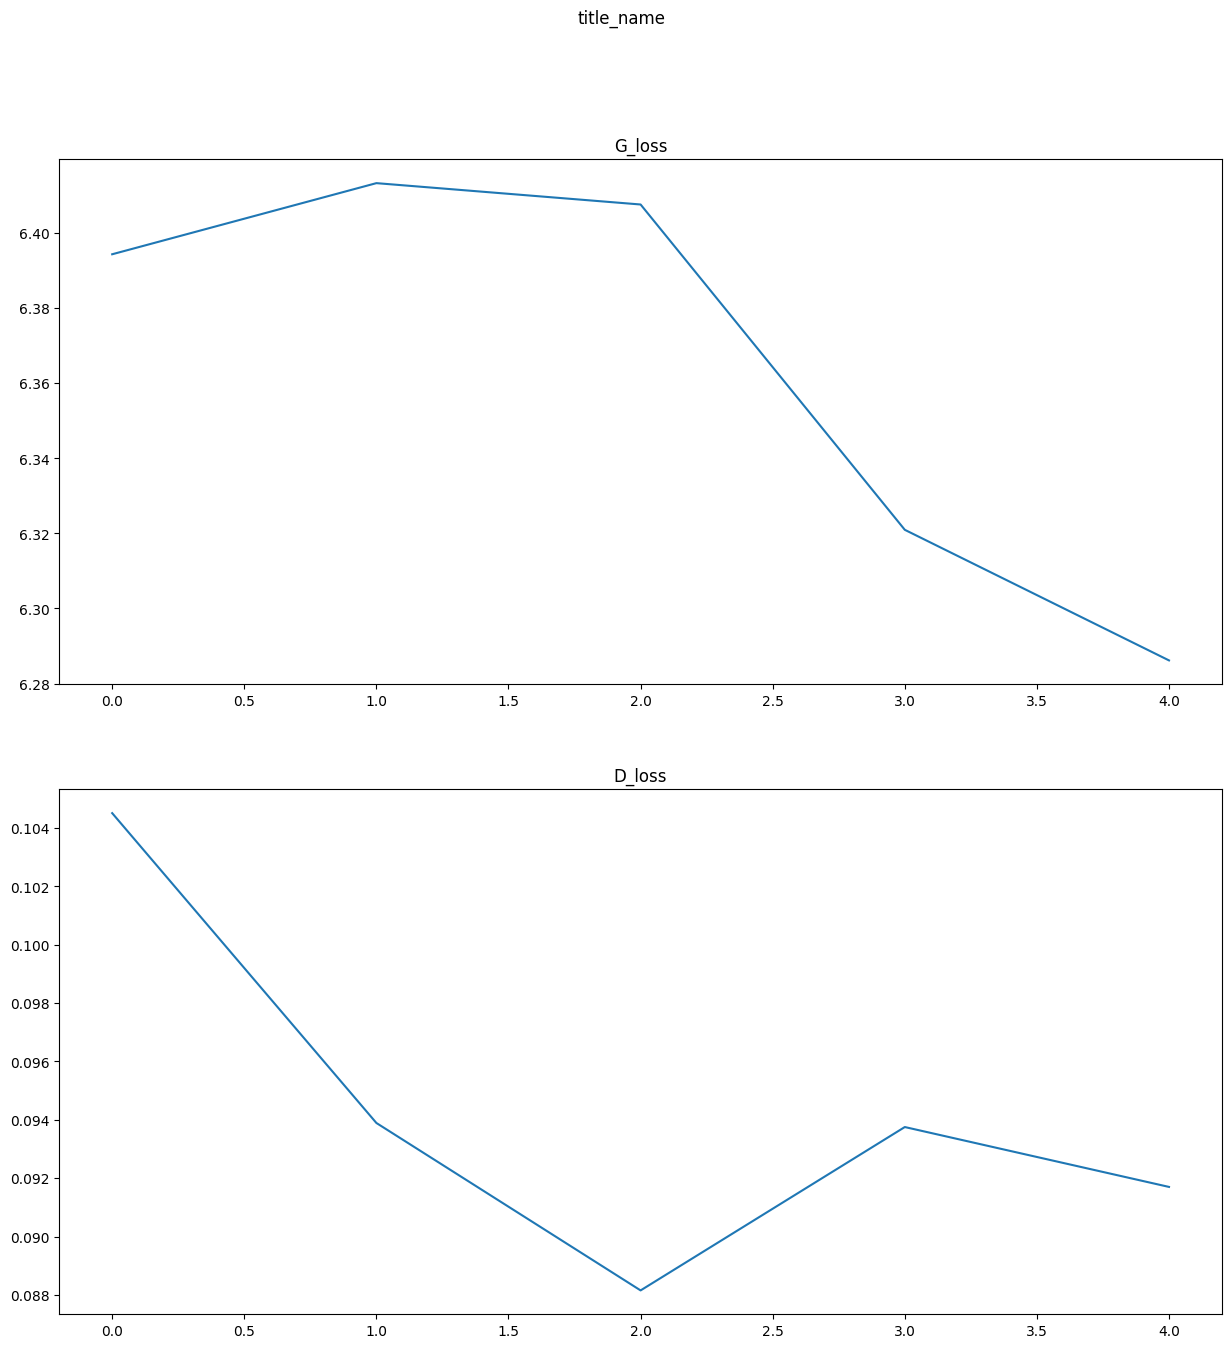

In [8]:
if __name__ == '__main__':
    showimg(g_loss_list, d_loss_list,"train")
    

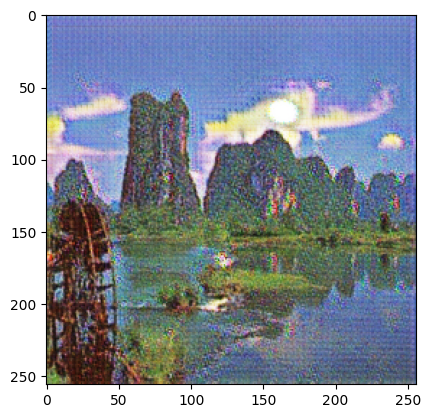

In [9]:

import torch
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import cv2
from PIL import Image


def test(img_path):
    if img_path.endswith('.png'):
        img = cv2.imread(img_path)
        img = img[:, :, ::-1]
    else:
        img = Image.open(img_path)

    transforms = transform.Compose([
        transform.ToTensor(),
        transform.Resize((256, 256), antialias=True),
        transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img = transforms(img.copy())
    img = img[None].to('cuda')  # [1,3,128,128]

    # 实例化网络
    Gb = Cycle_Gan_G().to('cuda')
    # 加载预训练权重
    ckpt = torch.load('/kaggle/working/weights/cycle_monent2photo.pth')
    Gb.load_state_dict(ckpt['Gb_model'], strict=False)

    Gb.eval()
    out = Gb(img)[0]
    #维度变换
    out = out.permute(1, 2, 0)
    out = (0.5 * (out + 1)).cpu().detach().numpy()
    plt.imsave('result123.jpg',out,format='jpg')
    plt.figure()
    plt.imshow(out)
    plt.show()


if __name__ == '__main__':
    test('/kaggle/input/cyclegan/123.jpg')


In [11]:
import torch.nn.functional as F

# 定义图像转换
image_transforms = transform.Compose([
        transform.ToTensor(),
        transform.Resize((256, 256), antialias=True),
        transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# 加载目标图像和生成图像
target_image_path = '/kaggle/input/cyclegan/123.jpg'  # 目标图像的路径
generated_image_path = '/kaggle/working/result123.jpg'  # 生成图像的路径

target_image = Image.open(target_image_path).convert('RGB')
generated_image = Image.open(generated_image_path).convert('RGB')

# 应用图像转换
target_image = image_transforms(target_image).unsqueeze(0)
generated_image = image_transforms(generated_image).unsqueeze(0)

# 将图像移至GPU（如果使用GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_image = target_image.to(device)
generated_image = generated_image.to(device)

#计算内容损失
content_loss = F.mse_loss(generated_image, target_image)#mse_loss为均方误差
print(content_loss)

tensor(0.0504, device='cuda:0')
